Ski Resort Recommender

In this notebook, we
1. build a recommender system to suggest ski resorts based off dataset of 18,261 user ratings
2. evaluate different approaches using mean average precision at K 
3. get top 5 recommendations for a given user
4. geolocate the lat/longs of those recommendations using Nominatim
5. pull weather and temperature of the resorts using openweathermap API
6. display results in a map of US mainland

In [1]:
#load packages
import os
%run packages.py

#load weather key from openweathermap - https://openweathermap.org/api/
load_dotenv()
key = os.environ.get('weather_key')

#read in our data - source: https://www.kaggle.com/code/kerneler/starter-onthesnow-ski-area-reviews-5c3726c8-0/input
if not os.path.exists('data'):
    os.makedirs('data')
df_original = pd.read_csv("./data/OnTheSnow_SkiAreaReviews.csv")

In [2]:
#format the data to feed the recommendation system
df = df_original.copy()

#remove reviews if there is no username - only ~100 observations so it shouldn't majorly affect the analysis
df = df[~df['Reviewer Name'].isnull().values]
df.rename(columns={'Review Star Rating (out of 5)':'rating'}, inplace=True)
df['user'] = df.groupby('Reviewer Name').ngroup()

#reduce to necessary columns 
df['resort'] = df['Ski Area'].str.replace('-', ' ').str.title()
df = df.copy()[['user', 'resort', 'rating']]

#filter out resorts with less than 20 ratings as they are less stable 
df['total_ratings'] = df.groupby('resort')['rating'].transform('count')
df = df[df.total_ratings>=20].reset_index(drop=True)

#keep at least one rating in the train set for each user to avoid cold start and shuffle for randomness
df = df.sample(frac=1).reset_index(drop=True)
df['count'] = df.groupby('user')['resort'].cumcount()    
train = df[(df['count']==0)].drop_duplicates()

#now split the remaining observations into train, validation and test sets with ~ 60-20-20 split
df = df[(df['count']!=0)].drop(columns = ['count'])
train2, test = train_test_split(df, test_size=0.38)
train2, val = train_test_split(train2, test_size=0.61)
train = pd.concat([train, train2])

#save our train, val and test data for replication
train.to_csv('./data/train.csv', index=False)
val.to_csv('./data/val.csv', index=False)
test.to_csv('./data/test.csv', index=False)


In [3]:
#define mean average precision @ k score for evaluation
def ap_score(true, pred, k):
    score = 0
    matches = 0
    for i,p in enumerate(pred):
        if p in true:
            matches += 1
            score += matches / (i+1)
    return score / min(len(true), k)

def map_at_k_score(zipped, k=5):
    #take the mean of the avg precision scores for each user
    return np.mean([ap_score(true, pred, k) for true, pred in zipped])


In [4]:
#chose number of 'popular' resorts
k = 5

#aggregate average ratings for each resort
train['avg_rating'] = train.groupby('resort')['rating'].transform(lambda x : np.nanmean(x))
pop = train.copy()[['resort', 'avg_rating', 'total_ratings']].drop_duplicates()

#keep top k resorts for all users 
pop = np.array(pop.sort_values(by = ['avg_rating', 'total_ratings'], ascending=False)[:k].resort)


#Evaluation

#validation
#only keep top ranked resorts as our 'true' set for good recommendations
true = val.sort_values(by = 'rating', ascending=False)
true['rank'] = true.groupby('user')['resort'].cumcount()
true = true[true['rank']<k] 
y_true = []
#get a list of the top k resorts for each user
for i in np.unique(true.user):
    y_true.append(np.unique(true[true.user==i].resort))
zipped = zip(y_true, [pop]*len(y_true))
print("Val MAP @k score:", map_at_k_score(zipped, k))

#test
true = test.sort_values(by = 'rating', ascending=False)
true['rank'] = true.groupby('user')['resort'].cumcount()
true = true[true['rank']<k] 
y_true = []
#get a list of the top k resorts for each user
for i in np.unique(true.user):
    y_true.append(np.unique(true[true.user==i].resort))
zipped = zip(y_true, [pop]*len(y_true))
print("Test MAP @k score:", map_at_k_score(zipped, k))


Val MAP @k score: 0.00435068349106204
Test MAP @k score: 0.006810207336523125


The naive approach gives us val MAP of 0.00435 and test MAP of 0.00681. Let's see if we can do better with latent factor collaborative filtering. Using explicit feedback, we hope our model can utilize previous user experience to improve recommendations. Unlike content based approaches, this allows us to refrain from gathering external information which might otherwise be difficult to collect. 

In [5]:
#Alternating Least Squares optimization approach

#collect resorts in a dictionary and convert resort to categorical
d = dict(enumerate(train.resort.astype('category').cat.categories))
train['resort_id'] = train['resort'].astype('category').cat.codes

#get sparse matrix for input into our model
train_user_item = sparse.csr_matrix((train['rating'].astype(float), (train['user'], train['resort_id'])))
val['resort_id'] = [list(d.keys())[list(d.values()).index(i)] for i in val.resort] 
val_user_item = sparse.csr_matrix((val['rating'].astype(float), (val['user'], val['resort_id'])))
test['resort_id'] = [list(d.keys())[list(d.values()).index(i)] for i in test.resort]  
test_user_item = sparse.csr_matrix((test['rating'].astype(float), (test['user'], test['resort_id'])))

#build ALS model, fit on train and tune parameters with val scores (like reg and iterations and factors)
threadpool_limits(1, "blas")
model = implicit.als.AlternatingLeastSquares(factors=40, regularization=0.01, iterations=50, random_state = 20)
model.fit(train_user_item)

#Evaluation - can use built in MAP@k score now 
print("Val MAP @ k:", mean_average_precision_at_k(model, train_user_item, val_user_item, K=k, show_progress=False, num_threads=1))
print("Test MAP @ k:", mean_average_precision_at_k(model, train_user_item, test_user_item, K=k, show_progress=False, num_threads=1))


  0%|          | 0/50 [00:00<?, ?it/s]

Val MAP @ k: 0.042794865054328786
Test MAP @ k: 0.045740297713981956


Collaborative filtering improves our MAP@k scores tenfold, resulting in val MAP@k of 0.0428 and test MAP@k of 0.0457 when solving via alternating least squares. We also look another collaborative filtering approach below relying on nearest neighbors. This approach takes advantage of similarity between different resorts to make new recommendations to users.

In [6]:
#We get the best results using BM25 distance shown below
model = implicit.nearest_neighbours.BM25Recommender(K=5)
model.fit(train_user_item.tocsr())

#evaluation - can use built in MAP score now 
print("Val MAP @ k:", mean_average_precision_at_k(model, train_user_item, val_user_item, K=k, show_progress=False, num_threads=1))
print("Test MAP @ k:", mean_average_precision_at_k(model, train_user_item, test_user_item, K=k, show_progress=False, num_threads=1))


/usr/local/lib/python3.10/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0002219676971435547 seconds
  warnings.warn(


  0%|          | 0/253 [00:00<?, ?it/s]

Val MAP @ k: 0.14113170347003118
Test MAP @ k: 0.14494927343611508


This approach performs significantly better, achieving validation and test MAP@k scores of 0.141 and 0.145, respectively. We choose this as our final recommender model for the visualization shown below. 

In [7]:
#choose user_id and get recommendations
user_id = 15
recommended_ids, _ = model.recommend(user_id, train_user_item[user_id], N = k)
resorts = [d[i] for i in recommended_ids]

print(resorts)

['Solitude Mountain Resort', 'Big Sky Resort', '49 Degrees North', 'Campgaw Mountain', 'Bear Mountain']


In [8]:
#geocode lat/longs for mapping 

#update format of state and resort to feed into the geocoder 
df_original['State'] = df_original['State'].str.replace('-', ' ').str.title()
df_original['Resort'] = df_original['Ski Area'].str.replace('-', ' ').str.title()

#initialize geolocater
geolocator = Nominatim(user_agent="my_user_agent")

lats = []
longs = []
resort = []
temps = []
weather =[]

for i in resorts:
    city = np.unique(df_original[df_original.Resort==i].Resort)[0]
    state = np.unique(df_original[df_original.Resort==i].State)[0]

    #geolocate
    loc = geolocator.geocode(city+','+ state)
    if loc:
        lats.append(loc.latitude)
        longs.append(loc.longitude)
        resort.append(np.unique(df_original[df_original.Resort==i].Resort)[0])
        
        #pull current temps and weather using open weather API 
        url = f"https://api.openweathermap.org/data/2.5/weather?lat={loc.latitude}&lon={loc.longitude}&appid={key}&units=imperial"
        temps.append(requests.get(url).json()['main']['temp'])
        weather.append(requests.get(url).json()['weather'][0]['main'])

lat_long = pd.DataFrame(
    {'Resort': resort,
     'lat': lats,
     'long': longs,
     'temp': temps,
     'weather': weather
    })

lat_long

,Resort,lat,long,temp,weather
0,Solitude Mountain Resort,40.623106,-111.597630,18.05,Clouds
1,Big Sky Resort,45.260492,-111.405978,14.77,Snow
2,49 Degrees North,47.734555,-122.290417,41.97,Clear
3,Campgaw Mountain,41.054263,-74.199193,63.37,Clear
4,Bear Mountain,36.746893,-119.280675,45.19,Clear


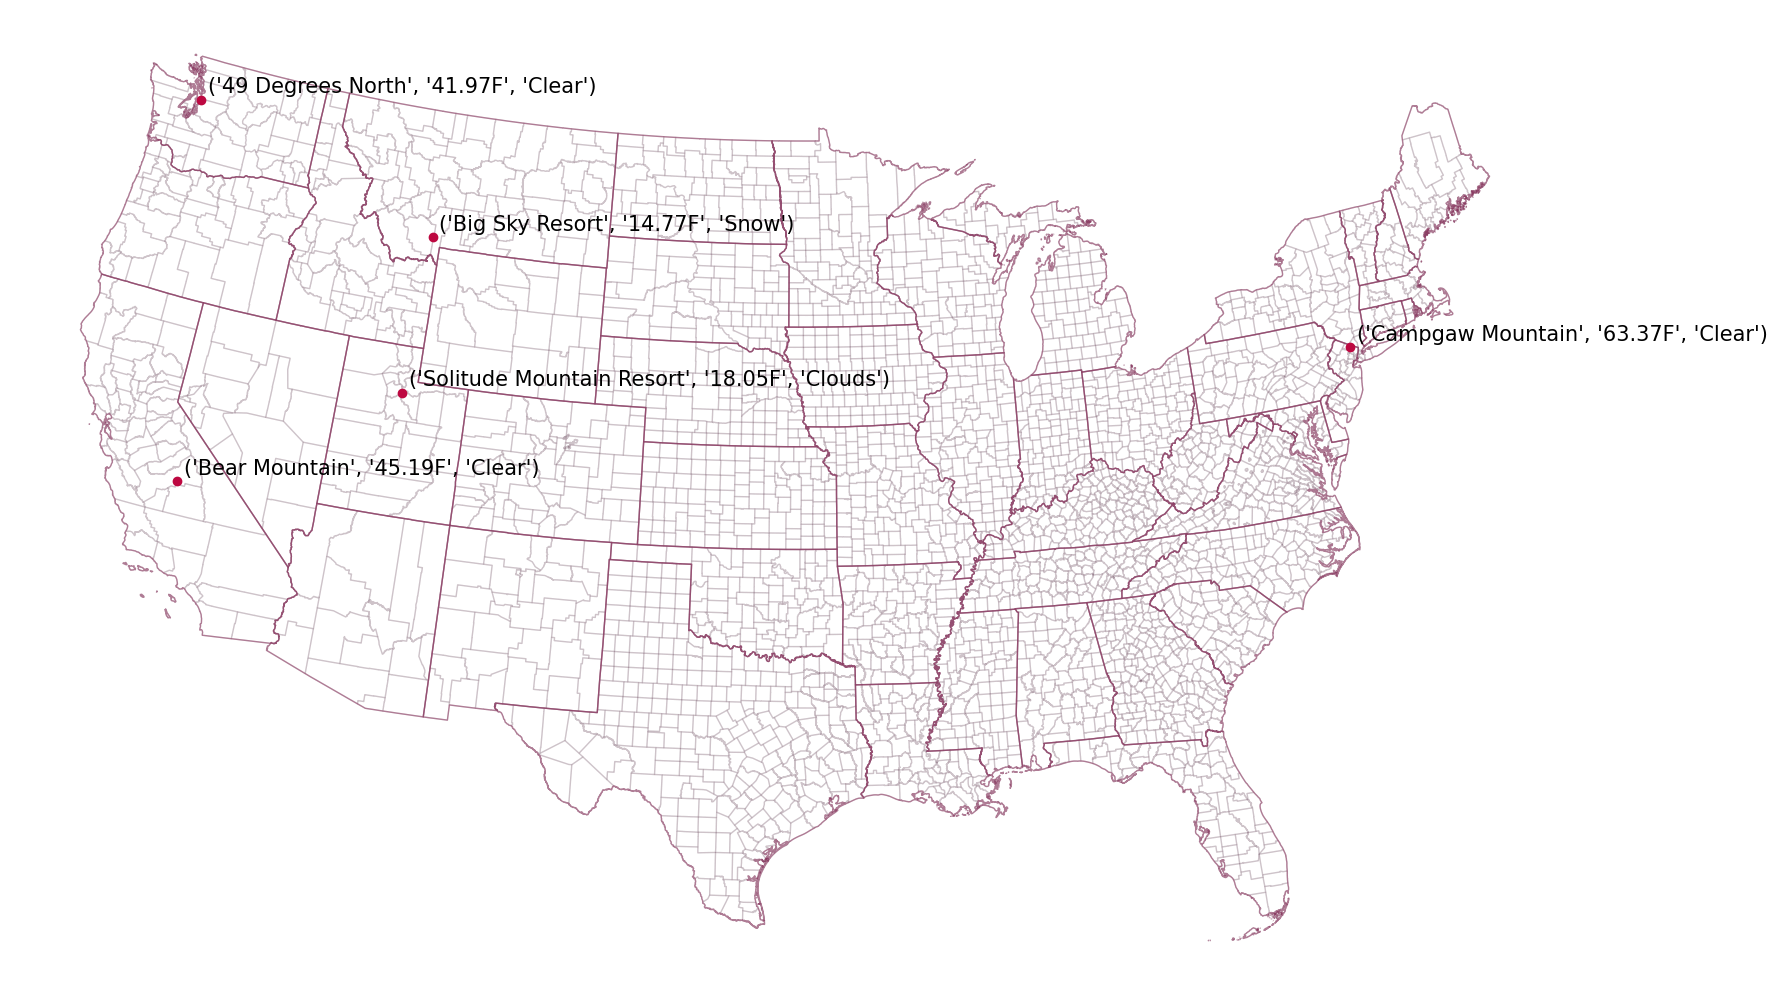

In [9]:
#mapping out our recommendations
 
#get outlines of county/state lines here:
#wget.download("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip")
#wget.download("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip")

#exclude US territories, alaska, hawaii
counties = gpd.read_file("./data/cb_2018_us_county_500k/")
counties = counties[~counties.STATEFP.isin(["72", "69", "60", "66", "78", "02", "15"])]
counties = counties.set_index("GEOID")

#exclude US territories, alaska, hawaii
states = gpd.read_file("./data/cb_2018_us_state_500k/")
states = states[~states.STATEFP.isin(["72", "69", "60", "66", "78", "02", "15"])]

#set to new coordinate reference system - contiguous US
counties = counties.to_crs("ESRI:102003")
states = states.to_crs("ESRI:102003")

#set up geopandas df and convert geometries to contigous US 
gdf = gpd.GeoDataFrame(
    lat_long, geometry=gpd.points_from_xy(lat_long.long, lat_long.lat), crs="EPSG:4326"
).to_crs("ESRI:102003")

#plot the county and state boundaries
ax = counties.plot(edgecolor='#30011E' + "20", color="None", figsize=(20, 20))
states.plot(ax=ax, edgecolor='#8b3a62', color="None", linewidth=1, alpha = 0.6)

#plot resorts and label with names and current weather patterns                        
gdf.plot(ax=ax, color='#bd0841')
gdf.apply(lambda x: ax.annotate(text=(x['Resort'],str(x['temp'])+"F",x['weather']), xy=x.geometry.centroid.coords[0], color = 'black', size=15, xytext=(5, 5), textcoords='offset points'), axis=1)

plt.axis("off")
plt.show()